In [1]:
# coding: utf-8

from time import time
from typing import Callable, Generator, Optional
from matplotlib import pyplot as plt

import numpy as np
import torch
from scipy.special import erf

from mugnier.heom.bath import BoseEinstein, Correlation, Drude, SpectralDensity, UnderdampedBrownian
from mugnier.heom.hierachy import HeomOp, NaiveHierachy, TrainHierachy, TreeHierachy
from mugnier.libs import backend
from mugnier.libs.backend import Array, OptArray
from mugnier.libs.logging import Logger
from mugnier.libs.quantity import Quantity as __
from mugnier.operator.spo import Propagator
from mugnier.basis import dvr

LIMITER = 10000


def ho(omega, center):
    return lambda x: 0.5 * omega**2 * (x - center)**2


def softmax(b):
    def func(x):
        return np.cos(np.pi * 0.5 * (erf(b * x) + 1))

    return func

def mid(b):

    def func(x):
        return np.sin(np.pi * 0.5 * (erf(b * x) + 1))

    return func



def left_morse(depth=1, frequency=1, center=-10):
    alpha = np.sqrt(frequency / 2.0 * depth)

    def func(x):
        return np.minimum(depth * (1.0 - np.exp(-alpha * (x - center)))**2,
                          LIMITER)

    return func


def right_morse(depth=1, frequency=1, center=10):
    alpha = np.sqrt(frequency / 2.0 * depth)

    def func(x):
        return np.minimum(depth * (1.0 - np.exp(alpha * (x - center)))**2,
                          LIMITER)

    return func


def gaussian(height=10, sigma=1, center=0, init_momentum=None):

    def func(x):
        if init_momentum is None:
            return height * np.exp(-(x - center)**2 / (2.0 * sigma**2))
        else:
            return height * np.exp(-(x - center)**2 /
                                   (2.0 * sigma**2)) * np.exp(
                                       -1.0j * x * init_momentum)

    return func


/home/vinylogy9/miniforge3/envs/mugnier/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


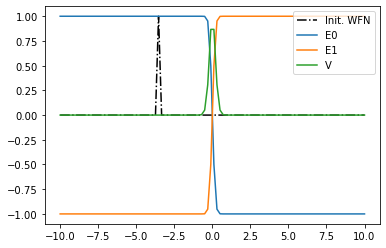

In [2]:
dvr_space = (-10, 10)
dvr_dim = 100
basis = dvr.SineDVR(dvr_space[0], dvr_space[1], dvr_dim)

grids = basis.grid_points
pes_freq = 1000
center0 = -2.5
center1 = 2.5
depth = 3
height = 0.5
coupling_width = 1

e0_func = softmax(3)
e1_func = softmax(3)
v_func = mid(3)
init_func = gaussian(1.0, 1.0 / np.sqrt(pes_freq), center0 - 1)
init_nuc = init_func(grids)
init_nuc /= np.linalg.norm(init_nuc)

plt.plot(grids, init_nuc.real, 'k-.', label='Init. WFN')
# plt.plot(grids, init_nuc.imag, 'r-.', label='WFN')
plt.plot(grids, e0_func(grids), label = 'E0')
plt.plot(grids, -e1_func(grids), label = 'E1')
plt.plot(grids, v_func(grids), label = 'V')
plt.legend()
# plt.ylim(-10, 10)
plt.show()

In [3]:
def run_dvr(
    # System
    ## Elec
    init_wfn: Array,
    ## Nuc
    dvr_space: tuple[float, float],
    dvr_dim: int,
    e0_func: Callable,
    e1_func: Callable,
    v_func: Callable,
    init_func: Callable,
    # Drudian bath
    include_drude: bool,
    re_d: Optional[float],
    width_d: float,
    # LTC bath
    temperature: float,
    decomposition_method: str,
    n_ltc: int,
    # Tensor Hierachy Tucker Decompositon
    dim: int,
    htd_method: str,
    # HEOM type
    heom_factor: float,
    ode_method: str,
    ps_method: str,
    reg_method: str,
    # Error
    roundoff: float,
    ode_rtol: float,
    ode_atol: float,
    svd_atol: float,
    # Propagator
    dt: float,
    end: float,
    callback_steps: int,
) -> Generator[tuple[float, OptArray], None, None]:

    backend.parameters.ode_rtol = ode_rtol
    backend.parameters.ode_atol = ode_atol
    backend.parameters.svd_atol = svd_atol

    # System settings:
    proj_0 = backend.array([[1.0, 0.0], [0.0, 0.0]])
    proj_1 = backend.array([[0.0, 0.0], [0.0, 1.0]])
    sigma_z = backend.array([[-0.5, 0.0], [0.0, 0.5]])
    sigma_x = backend.array([[0.0, 1.0], [1.0, 0.0]])

    # Elec-Nuc
    basis = dvr.SineDVR(dvr_space[0], dvr_space[1], dvr_dim)
    kinetic = np.tensordot(np.identity(2),
                           basis.t_mat,
                           axes=0).swapaxes(1, 2).reshape(2 * dvr_dim, 2 * dvr_dim)
    e0 = np.tensordot(proj_0,
                      np.diag(e0_func(basis.grid_points)),
                      axes=0).swapaxes(1, 2).reshape(2 * dvr_dim, 2 * dvr_dim)
    e1 = np.tensordot(proj_1,
                      np.diag(e1_func(basis.grid_points)),
                      axes=0).swapaxes(1, 2).reshape(2 * dvr_dim, 2 * dvr_dim)
    v = np.tensordot(sigma_x,
                     np.diag(v_func(basis.grid_points)),
                     axes=0).swapaxes(1, 2).reshape(2 * dvr_dim, 2 * dvr_dim)

    wfn = np.tensordot(init_wfn,
                       init_func(basis.grid_points),
                       axes=0).reshape(-1)
    wfn /= np.linalg.norm(wfn)
    init_rdo = np.outer(wfn, wfn)
    h = kinetic + e0 + e1 + v
    op = np.tensordot(sigma_z, np.identity(dvr_dim),
                      axes=0).swapaxes(1, 2).reshape(2 * dvr_dim, 2 * dvr_dim)

    # Bath settings:
    distr = BoseEinstein(
        n=n_ltc,
        beta=1 / temperature)
    distr.decomposition_method = decomposition_method
    sds = []  # type:list[SpectralDensity]
    if include_drude:
        drude = Drude(re_d, width_d)
        sds.append(drude)
    corr = Correlation(sds, distr)
    corr.fix(roundoff=roundoff)
    print(corr)

    # HEOM settings:
    dims = [dim] * corr.k_max
    if htd_method == 'Naive':
        s = NaiveHierachy(init_rdo, dims)
    else:
        raise NotImplementedError(f'No htd_method {htd_method}.')
    HeomOp.scaling_factor = heom_factor
    heom_op = HeomOp(s, h, op, corr, dims)

    # Propagator settings:
    steps = int(end / dt) * callback_steps
    interval = dt / callback_steps
    propagator = Propagator(heom_op,
                            s,
                            interval,
                            ode_method=ode_method,
                            ps_method=ps_method,
                            reg_method=reg_method)

    for _n, _t in zip(range(steps), propagator):
        if (_n + 1) % callback_steps == 0:
            rdo = s.get_rdo()
            trace = torch.trace(rdo)
            s.opt_update(s.root, s[s.root] / trace)
            rdo = s.get_rdo()
            pop = torch.diag(rdo).cpu().numpy()
            yield _t, pop

    return


In [4]:
it =  run_dvr(
    # System
    ## Elec
    init_wfn = [1, 0],
    ## Nuc
    dvr_space = dvr_space,
    dvr_dim = dvr_dim,
    e0_func = e0_func,
    e1_func = e1_func,
    v_func = v_func,
    init_func = init_func,
    # Drudian bath
    include_drude =False,
    re_d = 0.1,
    width_d = 0.1,
    # LTC bath
    temperature = 1,
    decomposition_method = 'Pade',
    n_ltc = 1,
    # Tensor Hierachy Tucker Decompositon
    dim = 5, 
    htd_method = 'Naive',
    # HEOM type
    heom_factor = 2.0,
    ode_method = 'dopri5',
    ps_method = 'ps1',
    reg_method = 'proper', 
    # Error
    roundoff = 1.e-8,
    ode_rtol= 1.e-5,
    ode_atol= 1.e-7,
    svd_atol= 1.e-7,
    # Propagator
    dt = 0.001,
    end = 10.,
    callback_steps = 1,
)

# for _t, pop in it:
#     print(_t, sum(pop))
#     plt.plot(basis.grid_points, pop[:dvr_dim].real)
#     plt.plot(basis.grid_points, pop[dvr_dim:].real)
#     plt.show()
#     plt.close()